In [94]:
import torch
import snntorch as snn
from snntorch import surrogate
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image,ImageEnhance
import os
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim 
import torch.optim as optim
import time
import numpy as np 
# from pyJoules.energy_meter import EnergyMeter
# from pyJoules.device.rapl_device import RaplPackageDomain
# from pyJoules.handler.csv_handler import CSVHandler

In [95]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [96]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(64)
        self.encoder_lif1 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())

        self.encoder_conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(128)
        self.encoder_lif2 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())

        self.encoder_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(256)
        self.encoder_lif3 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())

        # Decoder
        self.decoder_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(128)

        self.decoder_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(64)

        self.decoder_conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.output_activation = nn.Sigmoid()  # Outputs in range [0, 1]

        # Skip Connections
        self.skip_conv1 = nn.Conv2d(64, 64, kernel_size=1)
        self.skip_conv2 = nn.Conv2d(128, 128, kernel_size=1)
        # self.skip_conv3 = nn.Conv2d(3,3, kernel_size=1)

    def forward(self, x):
        # Initialize membrane potentials for spiking layers
        mem1 = self.encoder_lif1.init_leaky()
        mem2 = self.encoder_lif2.init_leaky()
        mem3 = self.encoder_lif3.init_leaky()

        # Encoder
        skip1 = self.encoder_bn1(self.encoder_conv1(x))
        spk1, mem1 = self.encoder_lif1(skip1, mem1)
        skip2 = self.encoder_bn2(self.encoder_conv2(spk1))
        spk2, mem2 = self.encoder_lif2(skip2, mem2)
        x = self.encoder_bn3(self.encoder_conv3(spk2))
        spk3, mem3 = self.encoder_lif3(x, mem3)

        # Decoder
        x = self.decoder_bn1(self.decoder_conv1(spk3))
        x += self.skip_conv2(skip2)  # Add skip connection
        x = self.decoder_bn1(self.decoder_conv1(spk3))
        

        x = self.decoder_bn2(self.decoder_conv2(x))
        x += self.skip_conv1(skip1)  # Add skip connection

        x = self.decoder_conv3(x)
        x = self.output_activation(x)  # Output in range [0, 1]

        return x


In [97]:
# Custom Dataset for grayscale and color images
class ColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform = transform
        self.grayscale_images = sorted(os.listdir(grayscale_dir))
        self.color_images = sorted(os.listdir(color_dir))

    def __len__(self):
        return len(self.grayscale_images)

    def __getitem__(self, idx):
        gray_img_path = os.path.join(self.grayscale_dir, self.grayscale_images[idx])
        color_img_path = os.path.join(self.color_dir, self.color_images[idx])

        gray_image = Image.open(gray_img_path).convert("L")
        color_image = Image.open(color_img_path)

        if self.transform:
            gray_image = self.transform(gray_image)
            color_image = self.transform(color_image)

        # Ensure grayscale image has a single channel dimension
        gray_image = gray_image.unsqueeze(0) if gray_image.dim() == 2 else gray_image

        return gray_image, color_image

In [98]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomVerticalFlip(p=0.3),
    # transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    # transforms.Normalize((0.4,), (0.4,))
])

In [99]:

# Load dataset
dataset = ColorizationDataset(
    grayscale_dir='Colorization_Main/Colorization_Main/data/test_black',
    color_dir='Colorization_Main/Colorization_Main/data/test_color',
    transform=transform
)

In [100]:
train_size = int(0.4 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_dataset = ColorizationDataset(
#     grayscale_dir='Colorization_Main/Colorization_Main/data/train_black',
#     color_dir='Colorization_Main/Colorization_Main/data/train_color',
#     transform=transform,
#     # color_transform=color_transform
# )

# test_dataset = ColorizationDataset(
#     grayscale_dir='Colorization_Main/Colorization_Main/data/test_black',
#     color_dir='Colorization_Main/Colorization_Main/data/test_color',
#     transform=transform,
#     # color_transform=color_transform
# )
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)


In [101]:
model = ColorizationModel().to(device)
model.load_state_dict(torch.load('colorization_model.pth', map_location=device))
model.eval()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

C:\Users\psono\AppData\Local\Temp\ipykernel_1016\138958703.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('colorization_model.pth', map

In [102]:
# # Training and Testing Functions
# def train_model(model, loader, criterion, optimizer):
#     model.train()
#     total_loss = 0
#     # Training loop
#     for gray, color in train_loader:
#         gray = gray.to(device)  # Move inputs to GPU
#         color = color.to(device)  # Move targets to GPU
#     # Ensure input shape is 4D
#         if len(gray.shape) == 5:
#             gray = gray.squeeze(1)  # If the second dimension is redundant
#         print(f"Gray shape: {gray.shape}")  # Debugging check

#         optimizer.zero_grad()
#         output = model(gray)  # Pass to model
#         loss = criterion(output, color)
#         loss.backward()
#         optimizer.step()


#     return total_loss / len(loader)

# def test_model(model, loader, criterion, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for gray, color in loader:
#             gray, color = gray.to(device), color.to(device)
#             output = model(gray)
#             loss = criterion(output, color)
#             total_loss += loss.item()
#     return total_loss / len(loader)

# # Model Initialization
# model = SNNColorization(input_channels=1, output_channels=3).to(device)
# criterion = nn.MSELoss()  # Mean Squared Error for pixel-wise colorization
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# epochs = 20
# for epoch in range(epochs):
#     train_loss = train_model(model, train_loader, criterion, optimizer)
#     test_loss = test_model(model, test_loader, criterion, device)
#     print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")



In [103]:
import matplotlib.pyplot as plt

def visualize_results(model, loader, device, num_images=5):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    with torch.no_grad():
        for gray, color in loader:
            gray, color = gray.to(device), color.to(device)
            output = model(gray)
            
            for i in range(len(gray)):
                if images_shown >= num_images:
                    break
                
                # Grayscale input
                input_img = gray[i].cpu().squeeze(0).numpy()
                # Ground truth
                gt_img = color[i].cpu().permute(1, 2, 0).numpy()
                # Predicted image
                pred_img = output[i].cpu().permute(1, 2, 0).numpy()

                # Plotting
                axes[images_shown, 0].imshow(input_img, cmap="gray")
                axes[images_shown, 0].axis("off")
                axes[images_shown, 0].set_title("Grayscale Input")

                axes[images_shown, 1].imshow(gt_img)
                axes[images_shown, 1].axis("off")
                axes[images_shown, 1].set_title("Ground Truth")

                axes[images_shown, 2].imshow(pred_img)
                axes[images_shown, 2].axis("off")
                axes[images_shown, 2].set_title("Prediction")

                images_shown += 1

            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()


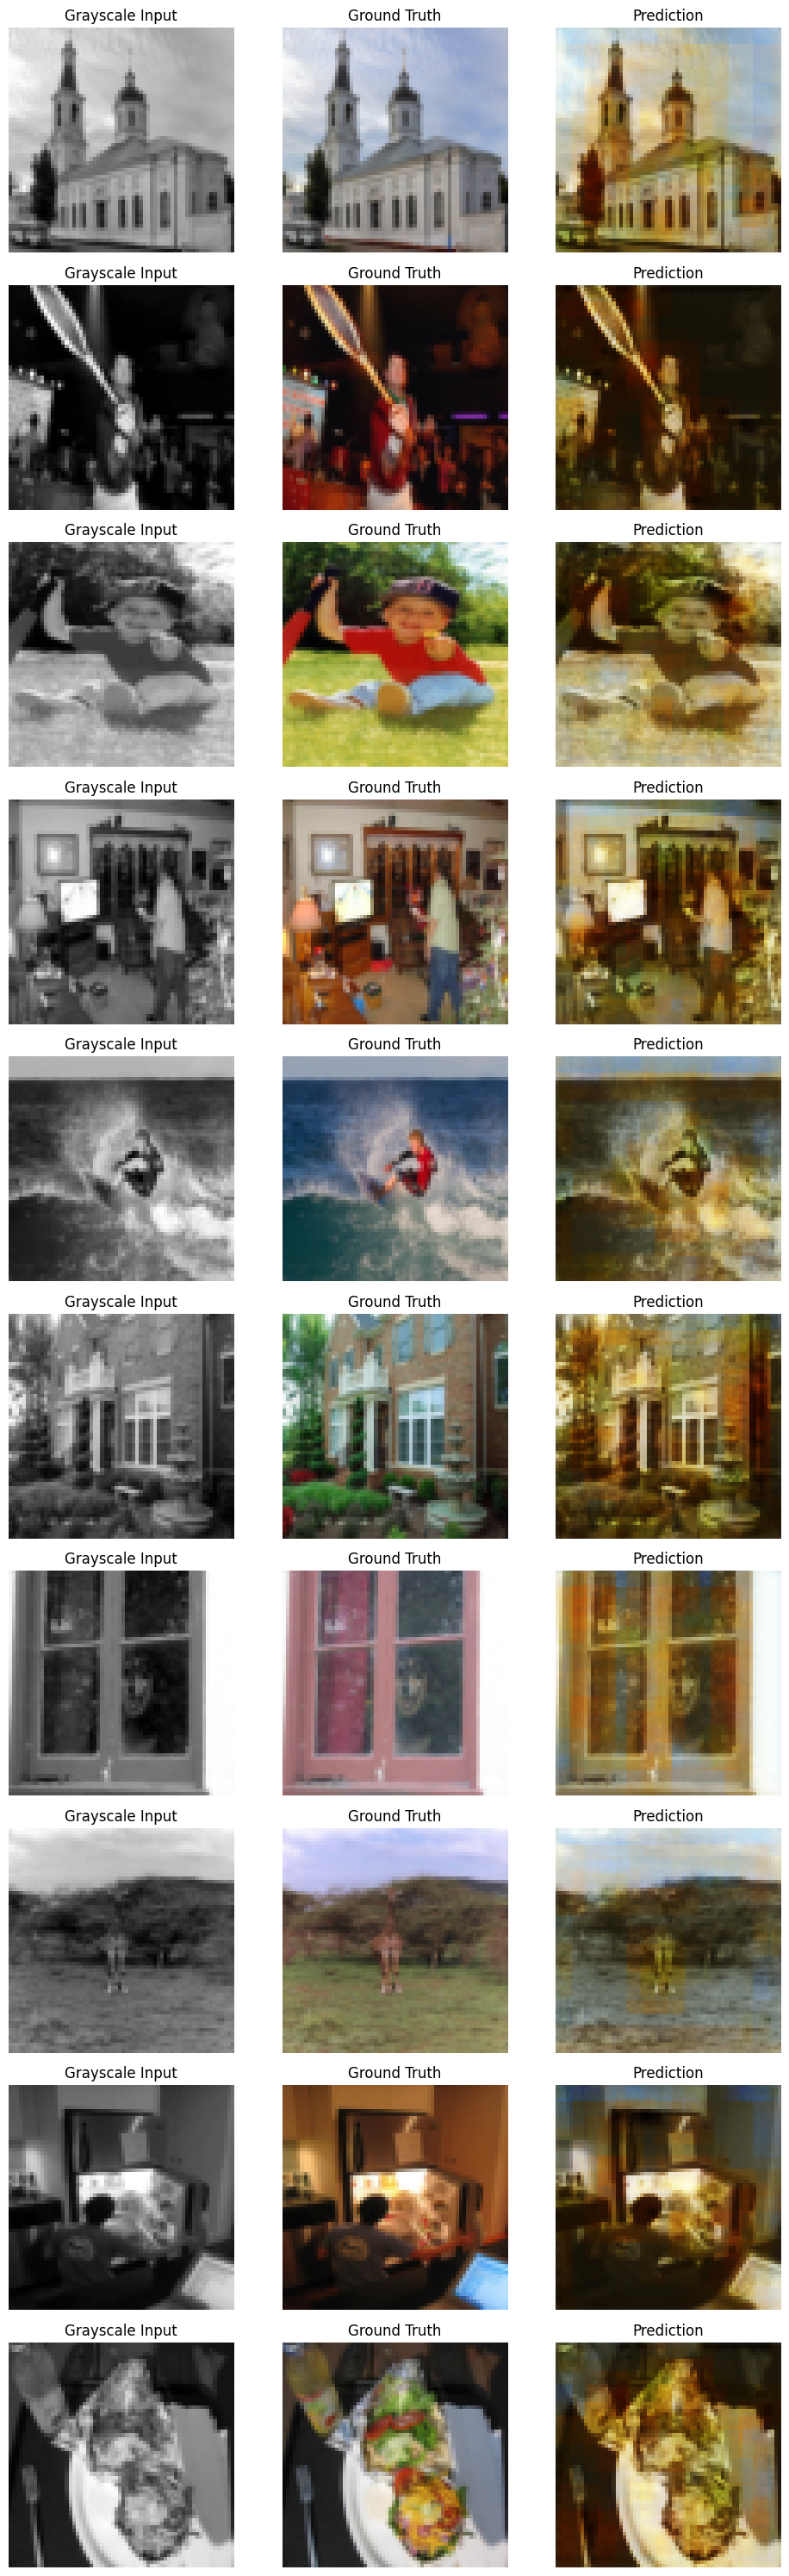

In [104]:
visualize_results(model, test_loader, device, num_images=10)


In [105]:
# Compute PSNR and SSIM metrics
def compute_metrics(outputs, targets):
    psnr_total = 0
    ssim_total = 0
    batch_size = outputs.size(0)
    
    for i in range(batch_size):
        output_img = outputs[i].permute(1, 2, 0).cpu().numpy()
        target_img = targets[i].permute(1, 2, 0).cpu().numpy()
        
        # Compute PSNR
        psnr_val = psnr(target_img, output_img, data_range=1.0)
        psnr_total += psnr_val
        
        # Compute SSIM with a smaller window size and specify channel_axis for color images
        ssim_val = ssim(target_img, output_img, data_range=1.0, win_size=3, channel_axis=2)
        ssim_total += ssim_val
        
    avg_psnr = psnr_total / batch_size
    avg_ssim = ssim_total / batch_size
    return avg_psnr, avg_ssim

In [106]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    batch_count = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for gray_images, color_images in test_loader:
            gray_images, color_images = gray_images.to(device), color_images.to(device)
            outputs = model(gray_images)
            loss = criterion(outputs, color_images)
            test_loss += loss.item()

            # Compute PSNR and SSIM for the current batch
            psnr_val, ssim_val = compute_metrics(outputs, color_images)
            psnr_total += psnr_val
            ssim_total += ssim_val
            batch_count += 1
    
    avg_test_loss = test_loss / len(test_loader)
    avg_psnr = psnr_total / batch_count
    avg_ssim = ssim_total / batch_count
    return avg_test_loss, avg_psnr, avg_ssim

In [107]:
# Calculate and print test metrics
test_loss, test_psnr, test_ssim = test_model(model, test_loader, criterion)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test PSNR: {test_psnr:.2f} dB")
print(f"Test SSIM: {test_ssim:.4f}")

Test Loss (MSE): 0.0138
Test PSNR: 19.12 dB
Test SSIM: 0.7836


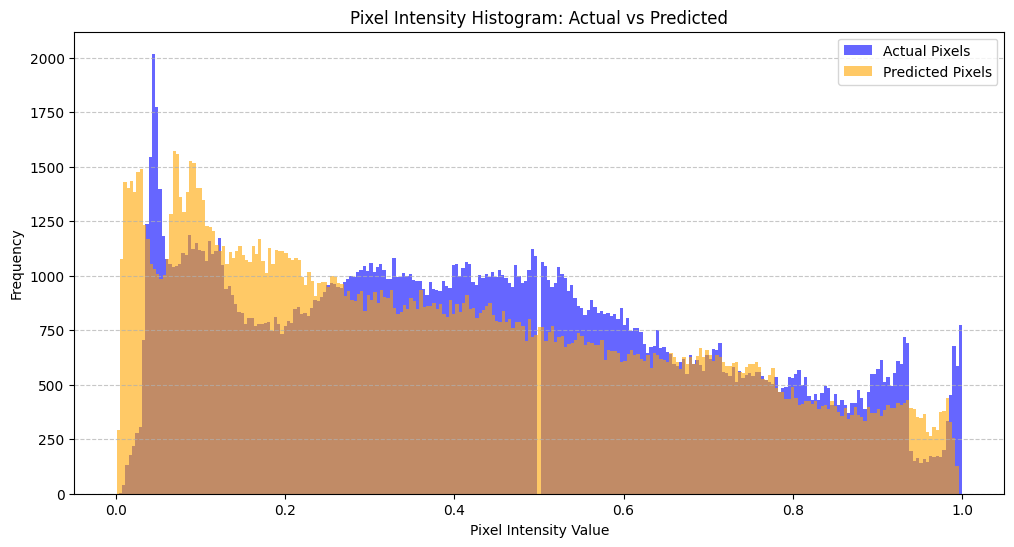

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_pixel_histogram(actual_images, predicted_images, num_bins=256):

    # Convert tensors to NumPy arrays
    actual_np = actual_images.cpu().numpy()
    predicted_np = predicted_images.cpu().numpy()
    
    # Flatten the pixel values for histogram calculation
    actual_flat = actual_np.flatten()
    predicted_flat = predicted_np.flatten()

    # Create histograms
    plt.figure(figsize=(12, 6))
    plt.hist(actual_flat, bins=num_bins, color='blue', alpha=0.6, label='Actual Pixels')
    plt.hist(predicted_flat, bins=num_bins, color='orange', alpha=0.6, label='Predicted Pixels')

    # Add title, labels, and legend
    plt.title('Pixel Intensity Histogram: Actual vs Predicted')
    plt.xlabel('Pixel Intensity Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage with test data
with torch.no_grad():
    for gray_images, color_images in test_loader:
        gray_images, color_images = gray_images.to(device), color_images.to(device)
        
        predicted_images = model(gray_images)

        # Call the histogram plotting function
        plot_pixel_histogram(color_images, predicted_images)
        break  # Only visualize for the first batch


In [109]:
def psnr(y_true, y_pred):
    mse = np.mean(np.square(y_true - y_pred))
    return 10 * np.log10((255 ** 2) / mse)

psnr_scores = np.array([psnr(x_test_color[i], y_pred[i]) for i in range(len(x_test_color))])
average_psnr = np.mean(psnr_scores)
print(f"Average PSNR: {average_psnr:.4f}")


NameError: name 'x_test_color' is not defined